 # <h1 style='background:#F7B2B0; border:0; color:black'><center>Energy Consumption Prediction</center></h1> 

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use.

According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.

# **<span style="color:#F7B2B0;">Goal</span>**
 
The goal of this competition is to predict the energy consumption using building characteristics and climate and weather variables .

# **<span style="color:#F7B2B0;">Data</span>**

The ML model focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.


**Files**
> - ``` train.csv``` - the training dataset where the observed values of the Site EUI for each row is provided
> - ```test.csv``` - the test dataset where we withhold the observed values of the Site EUI for each row. 
> - ```sample_submission.csv``` - a sample submission file in the correct format

**Columns**

> - ```id:``` building id

> - ```Year_Factor:``` anonymized year in which the weather and energy usage factors were observed

> - ```State_Factor:``` anonymized state in which the building is located

> - ```building_class:``` building classification

> - ```facility_type:``` building usage type

> - ```floor_area:``` floor area (in square feet) of the building

> - ```year_built:``` year in which the building was constructed

> - ```energy_star_rating:``` the energy star rating of the building

> - ```ELEVATION:``` elevation of the building location

> - ```january_min_temp:``` minimum temperature in January (in Fahrenheit) at the location of the building

> - ```january_avg_temp:``` average temperature in January (in Fahrenheit) at the location of the building

> - ```january_max_temp:``` maximum temperature in January (in Fahrenheit) at the location of the building

> - ```cooling_degree_days:``` cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

> - ```heating_degree_days:``` heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

> - ```precipitation_inches:``` annual precipitation in inches at the location of the building

> - ```snowfall_inches:``` annual snowfall in inches at the location of the building

> - ```snowdepth_inches:``` annual snow depth in inches at the location of the building

> - ```avg_temp:``` average temperature over a year at the location of the building

> - ```days_below_30F:``` total number of days below 30 degrees Fahrenheit at the location of the building

> - ```days_below_20F:``` total number of days below 20 degrees Fahrenheit at the location of the building

> - ```days_below_10F:``` total number of days below 10 degrees Fahrenheit at the location of the building

> - ```days_below_0F:``` total number of days below 0 degrees Fahrenheit at the location of the building

> - ```days_above_80F:``` total number of days above 80 degrees Fahrenheit at the location of the building

> - ```days_above_90F:``` total number of days above 90 degrees Fahrenheit at the location of the building

> - ```days_above_100F:``` total number of days above 100 degrees Fahrenheit at the location of the building

> - ```days_above_110F:``` total number of days above 110 degrees Fahrenheit at the location of the building

> - ```direction_max_wind_speed:``` wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

> - ```direction_peak_wind_speed:``` wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

> - ```max_wind_speed:``` maximum wind speed at the location of the building

> - ```days_with_fog:``` number of days with fog at the location of the building


# **<span style="color:#F7B2B0;">Evaluation Metric</span>**

The evaluation metric for this competition is Root Mean Squared Error (RMSE). The RMSE is commonly used measure of the differences between predicted values provided by a model and the actual observed values. 



In [1]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("api_key")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
CONFIG = dict(competition = 'WiDSDatathon2022',_wandb_kernel = 'tensorgirl')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [2]:
import os
import gc
import copy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold ,RepeatedKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

import shap

from sklearn.preprocessing import StandardScaler

import optuna.integration.lightgbm as lgbm
import optuna


import warnings
warnings.filterwarnings('ignore')

import wandb

In [3]:
train = pd.read_csv("../input/widsdatathon2022/train.csv")
test = pd.read_csv("../input/widsdatathon2022/test.csv")
print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)
categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features=train.select_dtypes('number').columns

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [4]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


# **<span style="color:#F7B2B0;">Missing Values</span>**

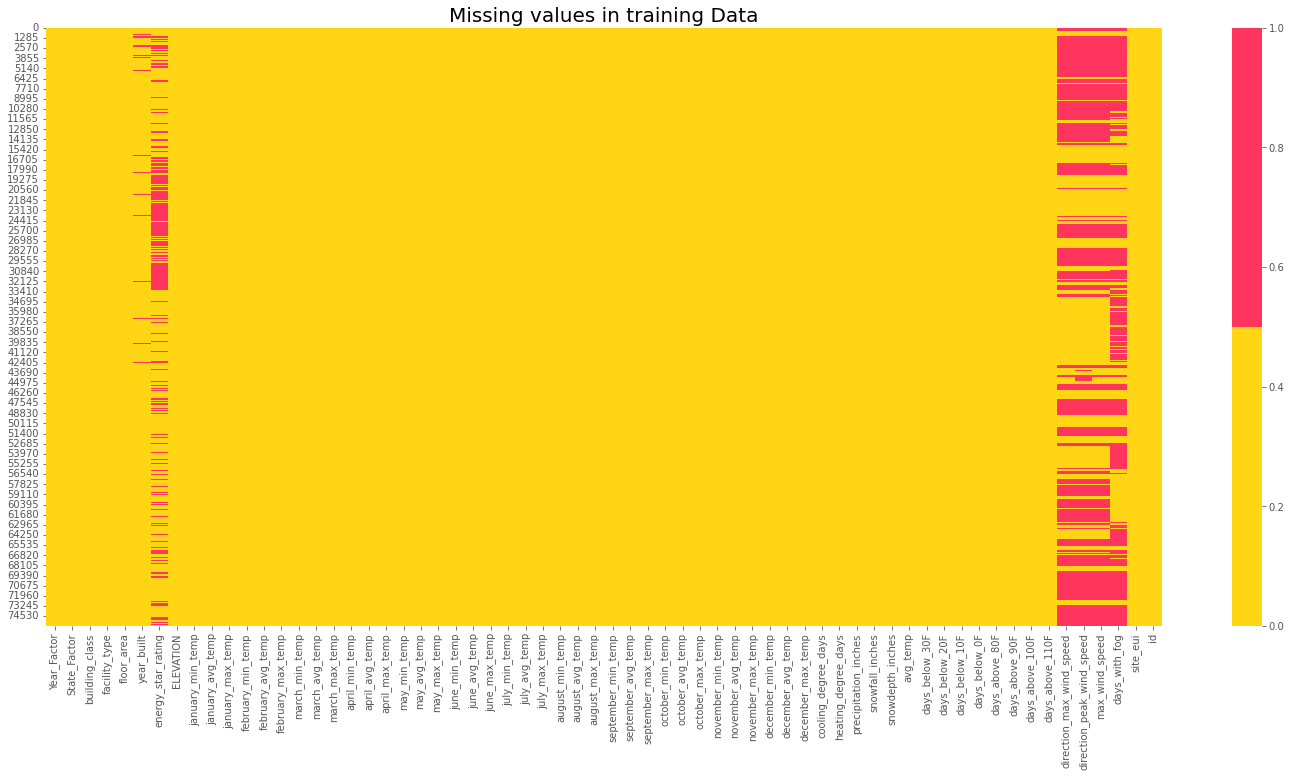

In [5]:
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, cmap = ['#ffd514','#ff355d'], xticklabels=train.columns)
plt.title("Missing values in training Data", size=20);

In [6]:
#code copied from https://www.kaggle.com/shrutisaxena/wids2022-starter-code
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

,Null Values Count
year_built,1837
energy_star_rating,26709
direction_max_wind_speed,41082
direction_peak_wind_speed,41811
max_wind_speed,41082
days_with_fog,45796


In [7]:
# basic stats of features
train.describe().style.background_gradient(cmap="Pastel1")

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,75757.000000,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,165983.865858,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,246875.790940,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,943.000000,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,62379.000000,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.000000,3978

# **<span style="color:#F7B2B0;">Target variable distribution</span>**

<AxesSubplot:xlabel='site_eui'>

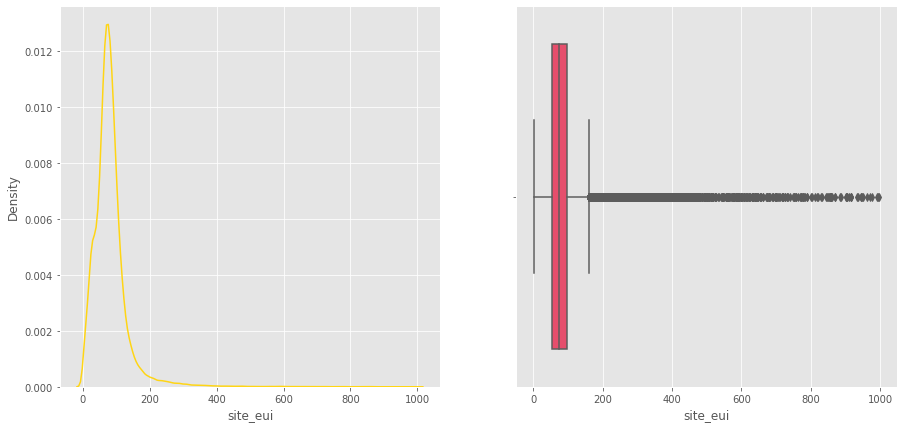

In [8]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.kdeplot(train.site_eui , color = "#ffd514")
plt.subplot(122)
sns.boxplot(train.site_eui , color = "#ff355d")


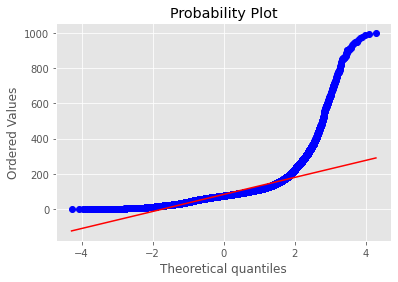

In [9]:
res = stats.probplot(train['site_eui'], plot=plt)

In [10]:
def kdeplot_features(df_train,df_test, feature, title):
    '''Takes a column from the dataframe and plots the distribution (after count).'''
    
    values_train = df_train[feature].to_numpy()
    values_test = df_test[feature].to_numpy()  
     
    plt.figure(figsize = (18, 3))
    
    sns.kdeplot(values_train, color = '#ffd514')
    sns.kdeplot(values_test, color = '#ff355d')
    
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show();
    
    del values_train , values_test
    gc.collect()
    
def countplot_features(df_train, feature, title):
    '''Takes a column from the dataframe and plots the distribution (after count).'''
    
           
    plt.figure(figsize = (10, 5))
    
    sns.countplot(df_train[feature], color = '#ff355d')
        
    plt.title(title, fontsize=15)    
    plt.show();
    
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})


# **<span style="color:#F7B2B0;">Distribution of Numeric Variables</span>**

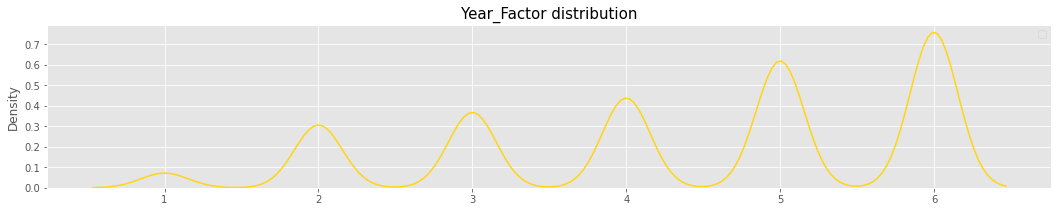

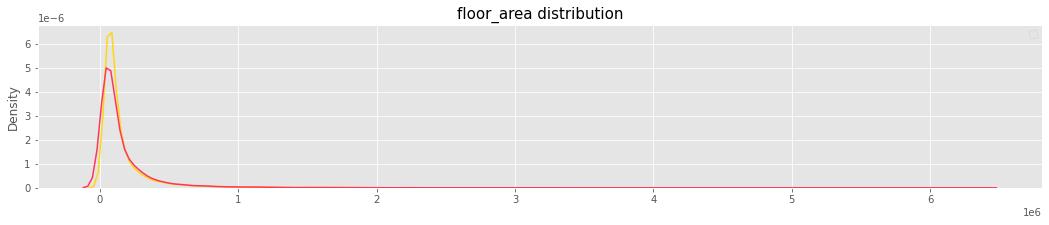

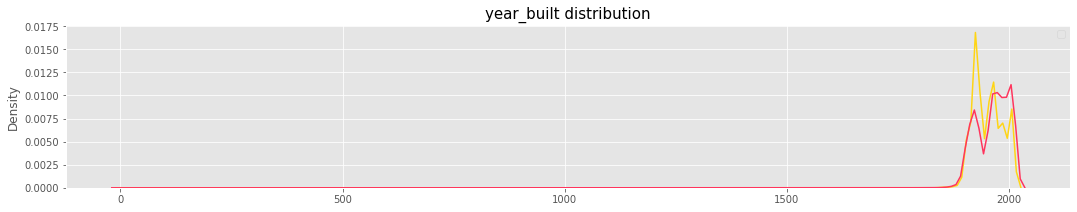

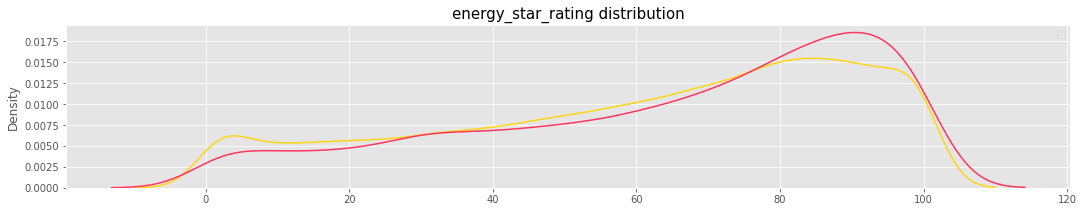

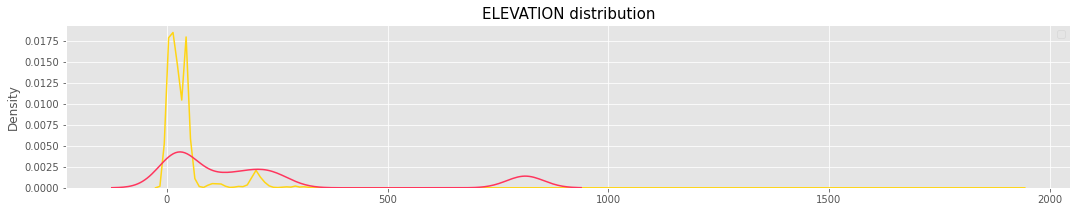

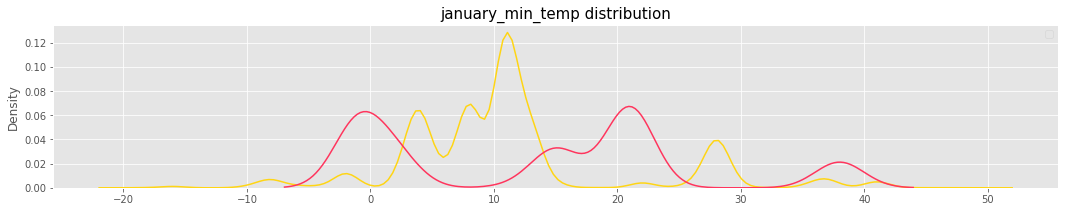

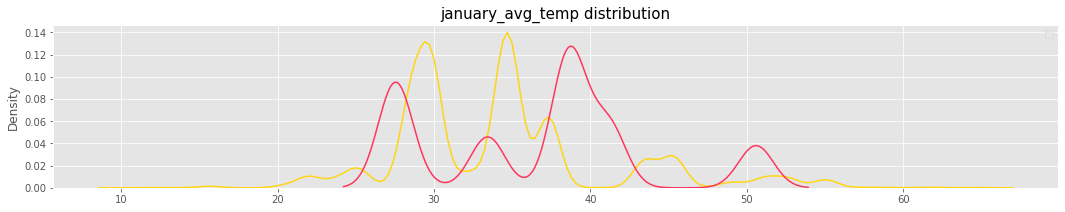

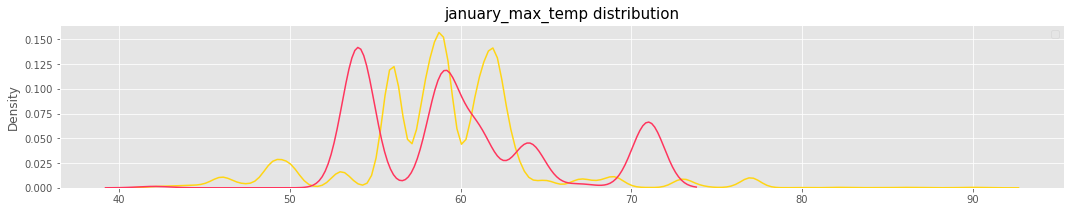

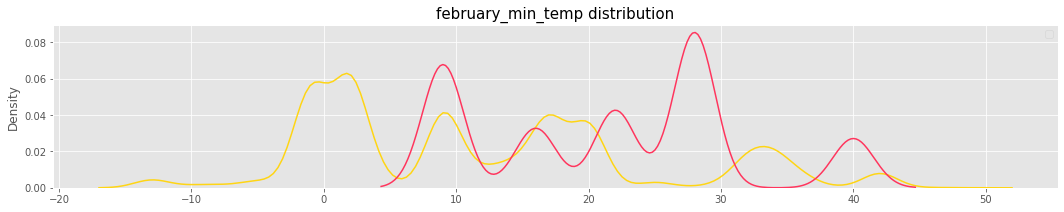

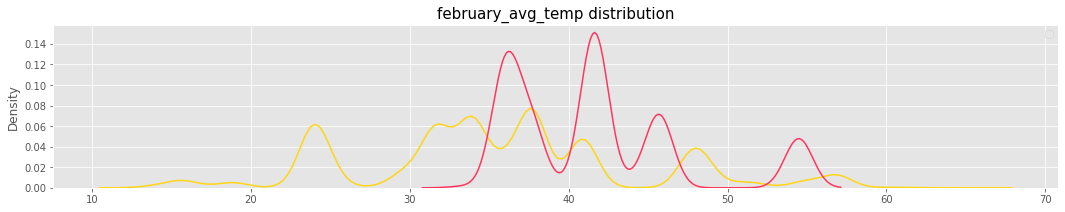

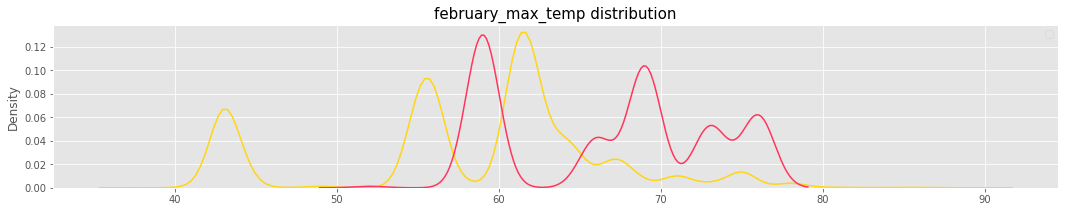

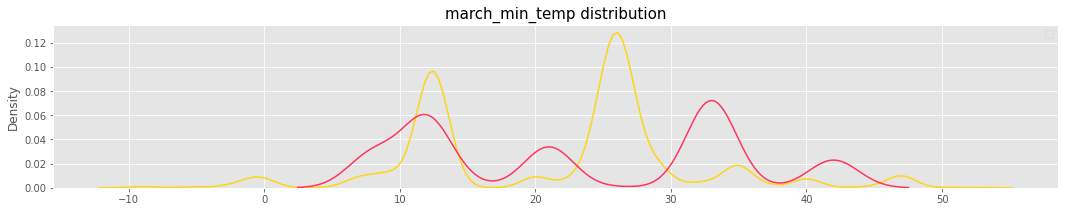

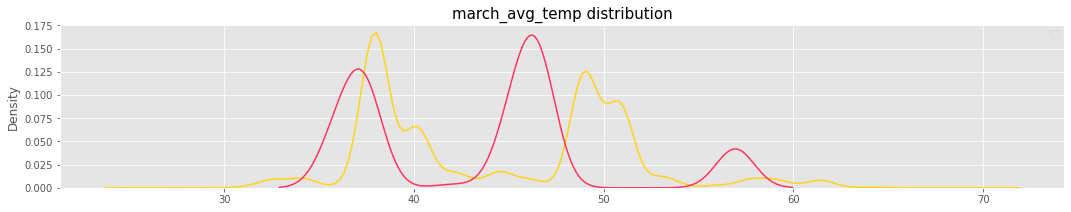

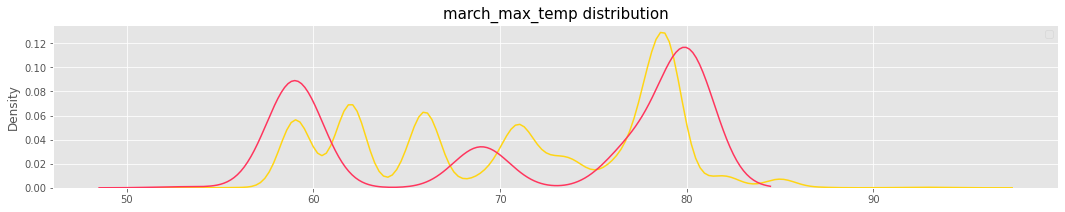

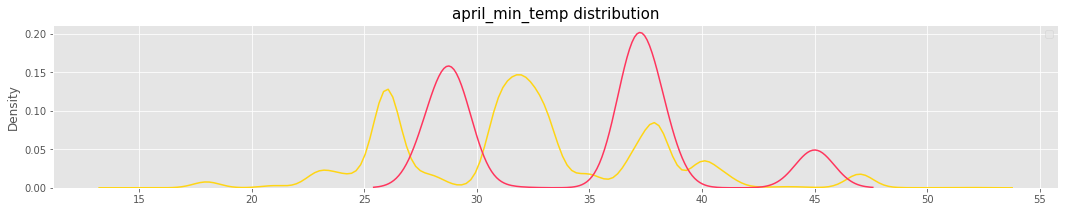

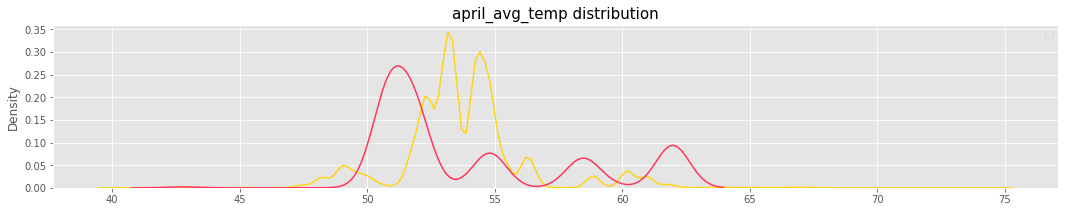

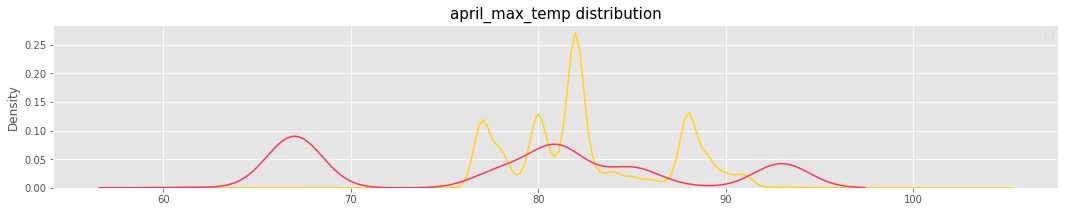

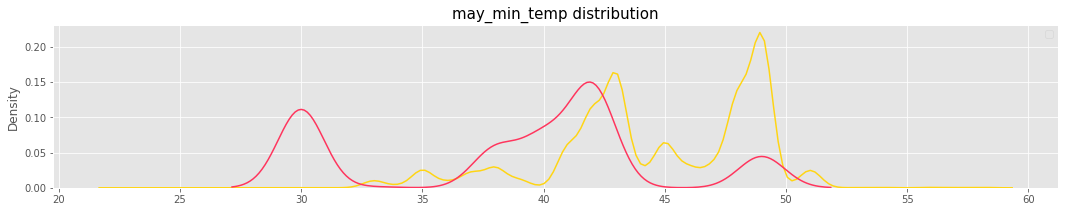

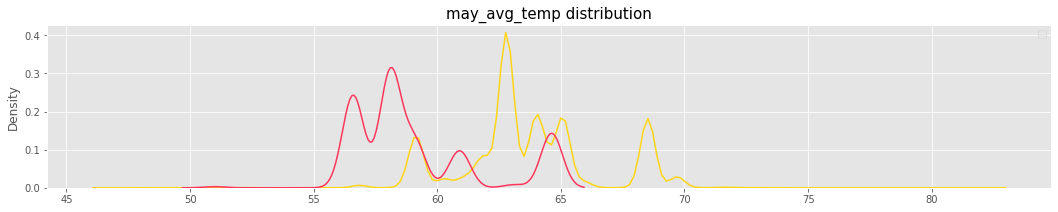

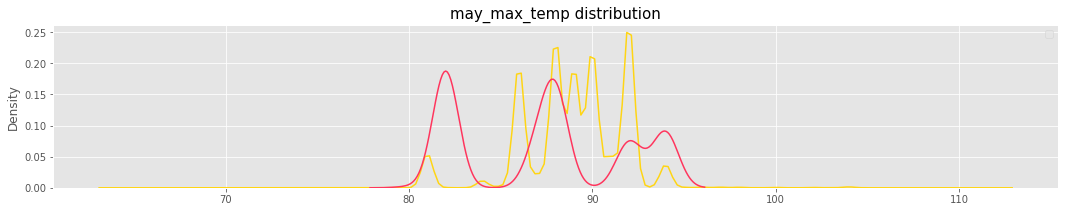

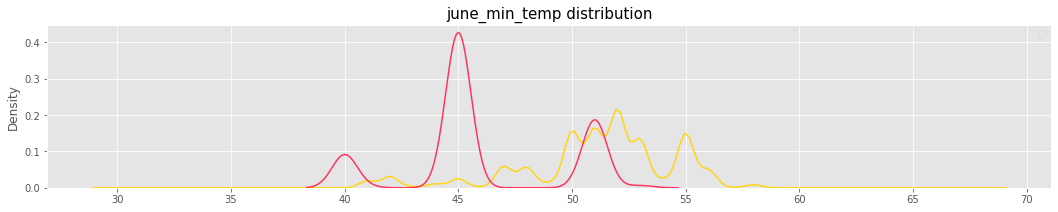

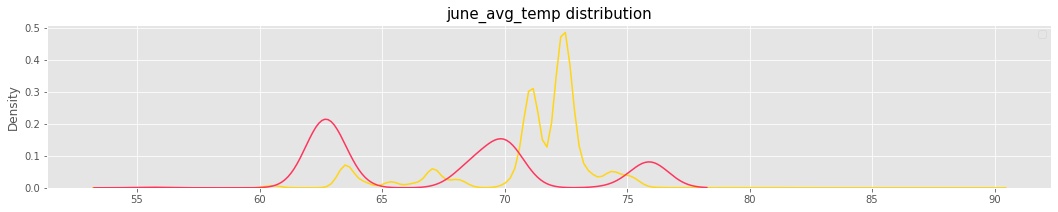

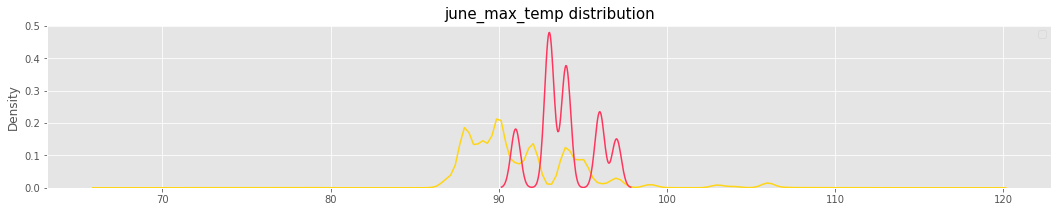

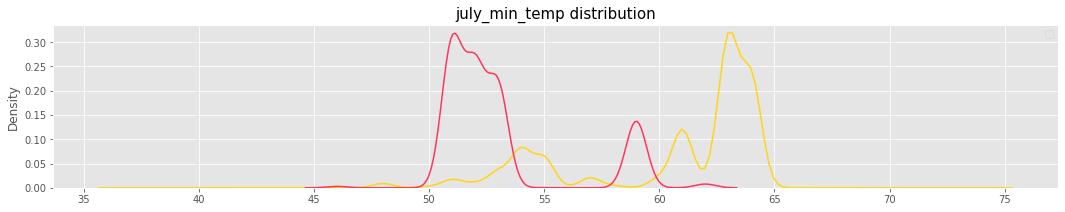

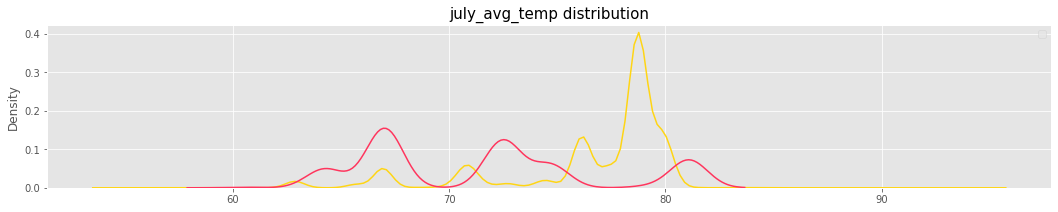

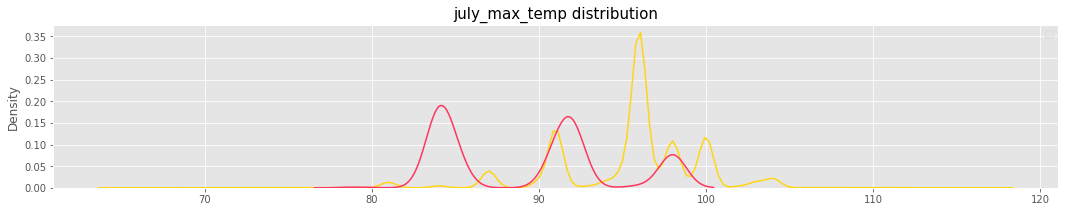

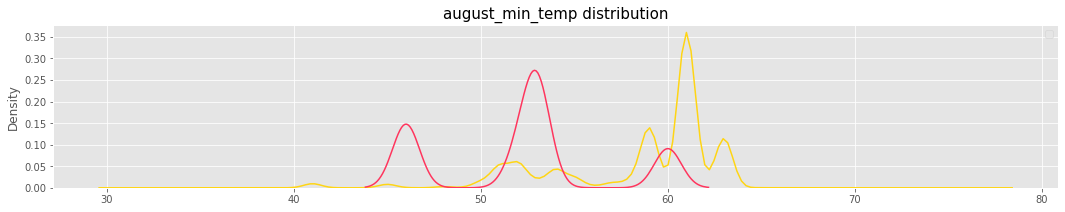

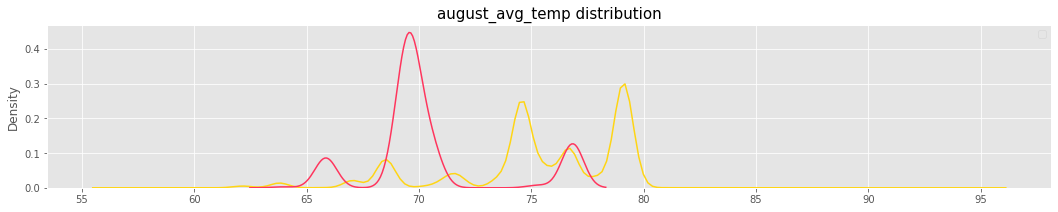

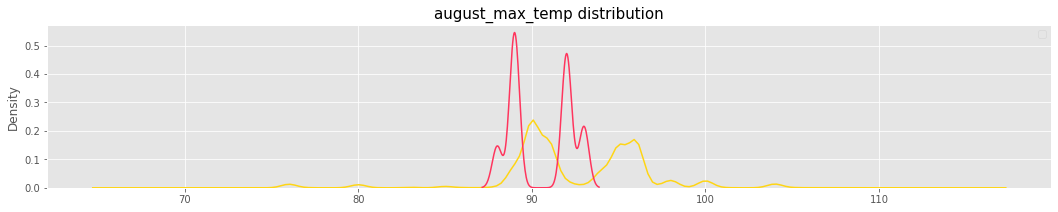

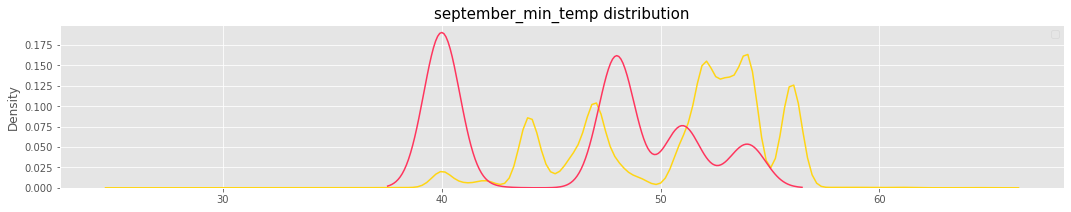

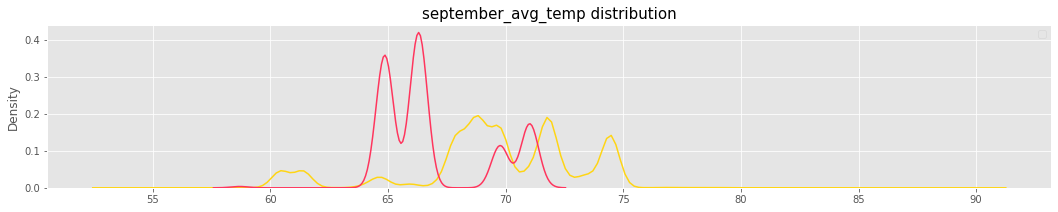

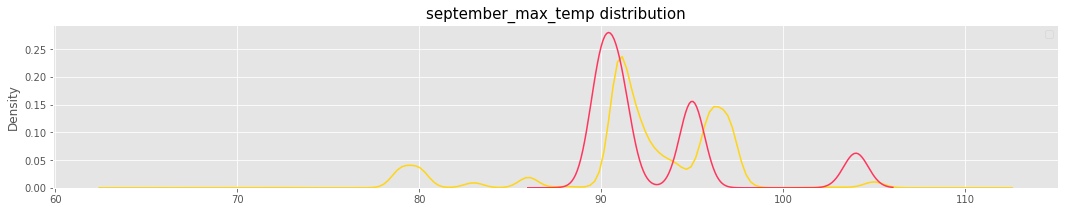

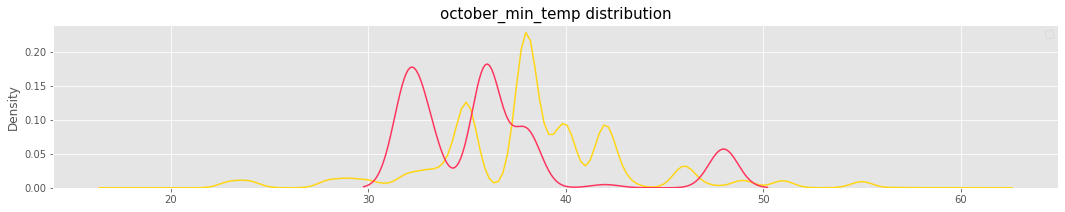

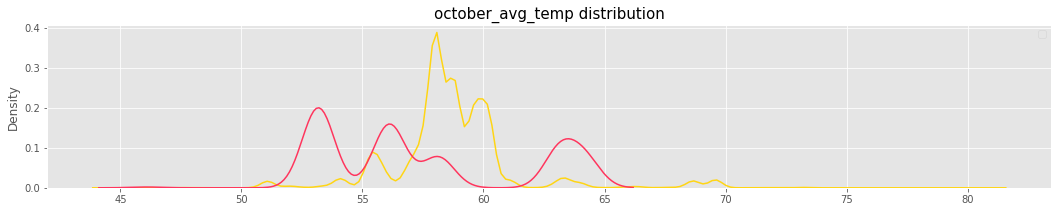

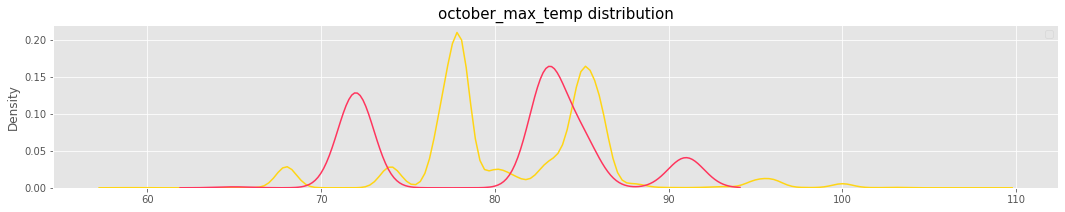

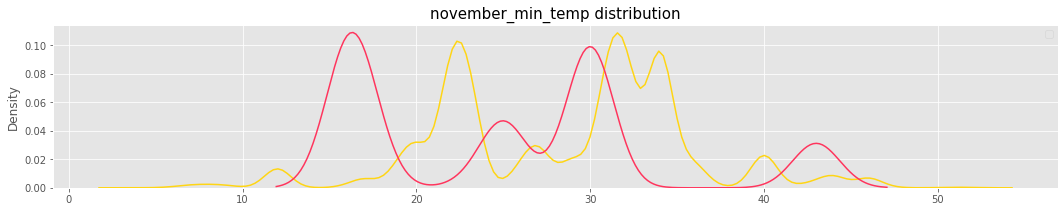

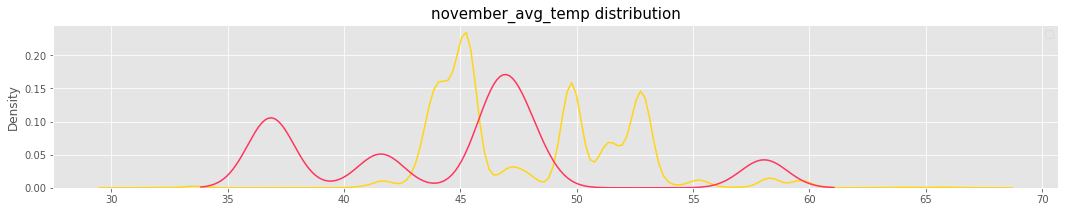

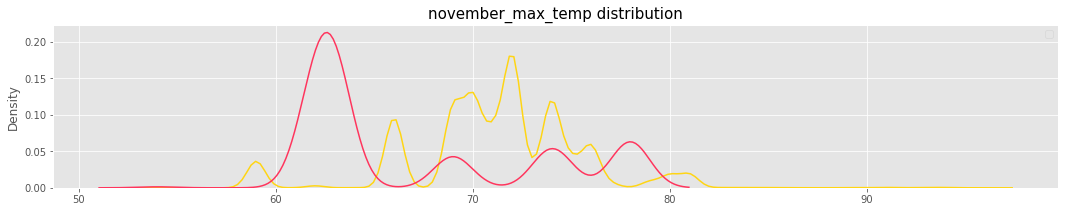

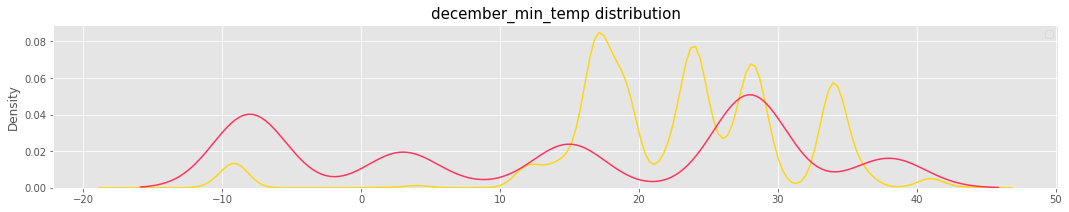

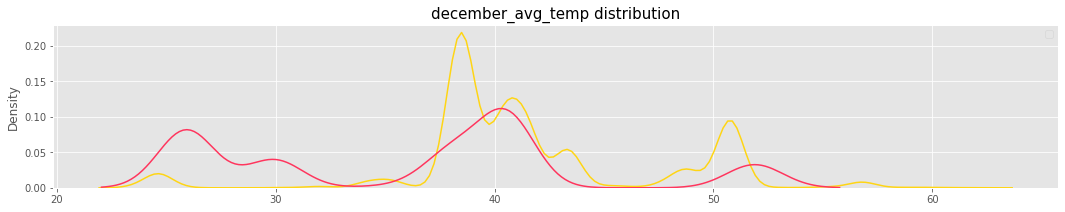

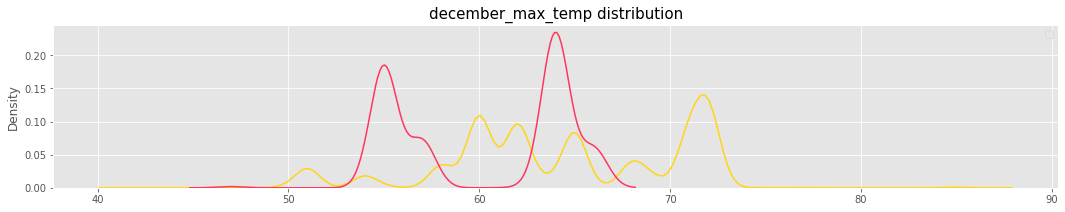

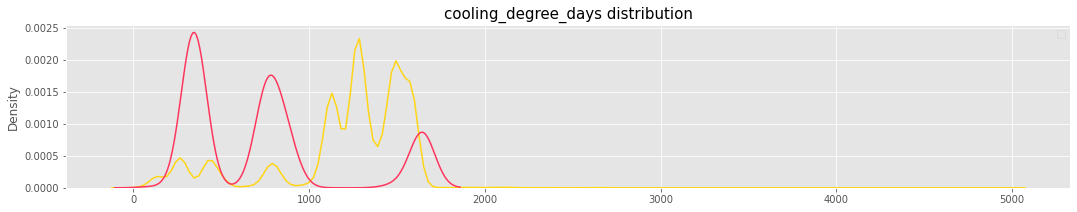

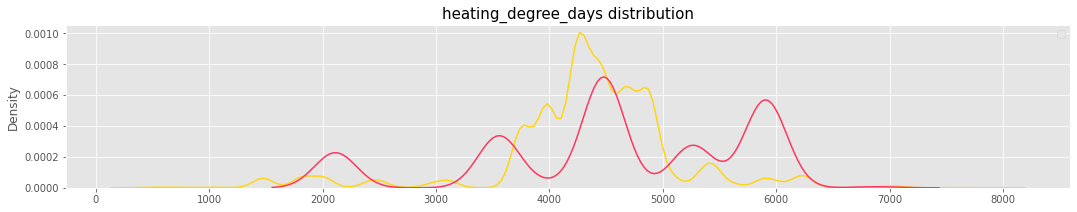

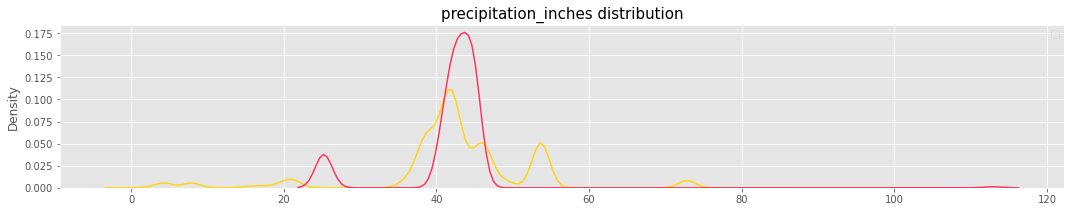

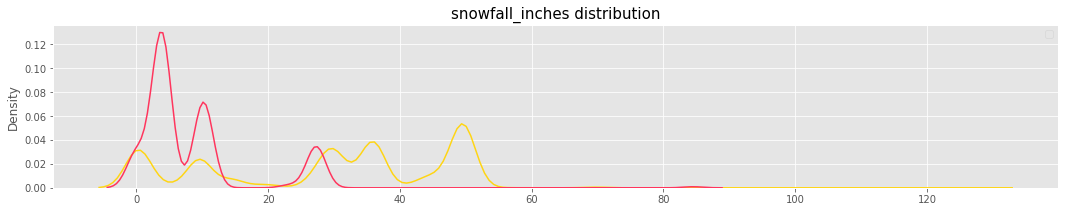

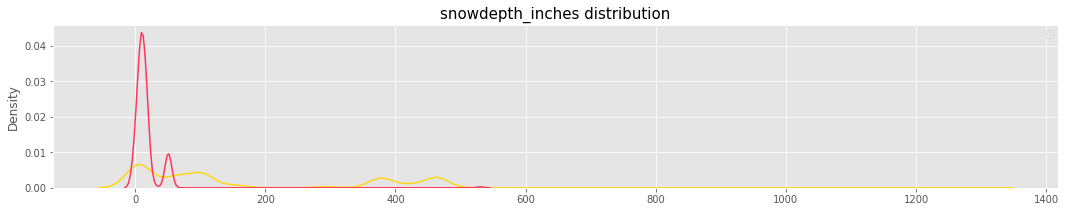

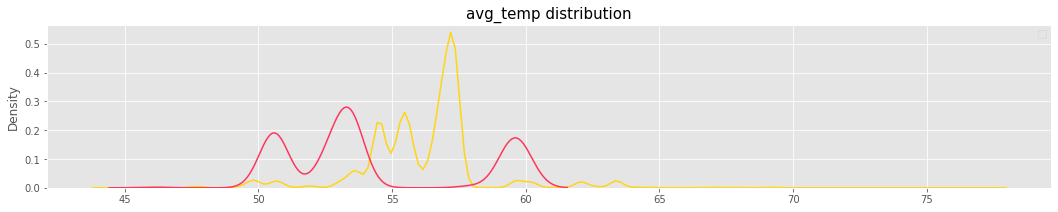

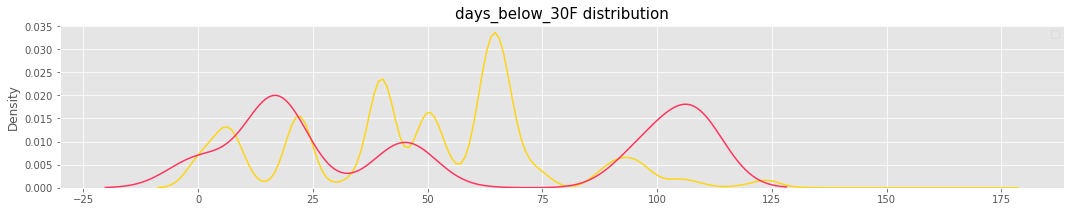

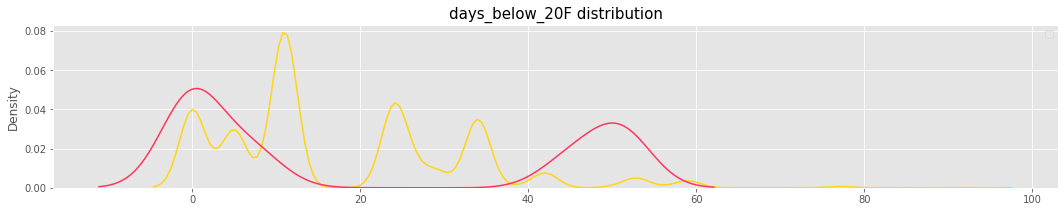

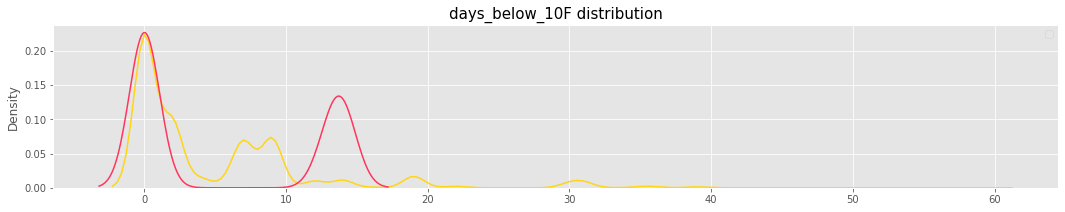

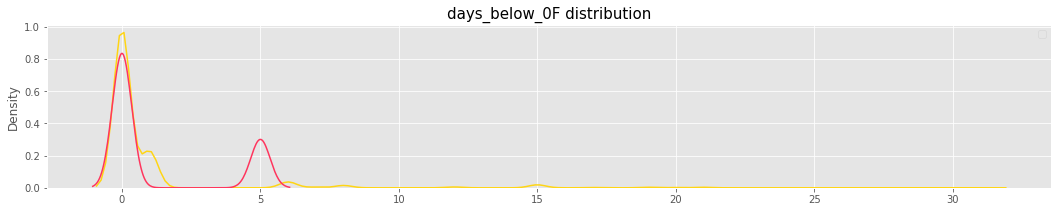

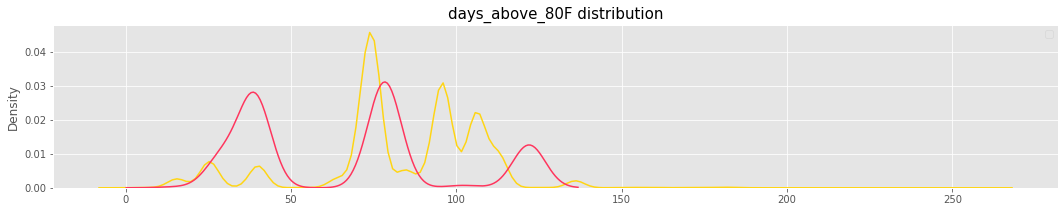

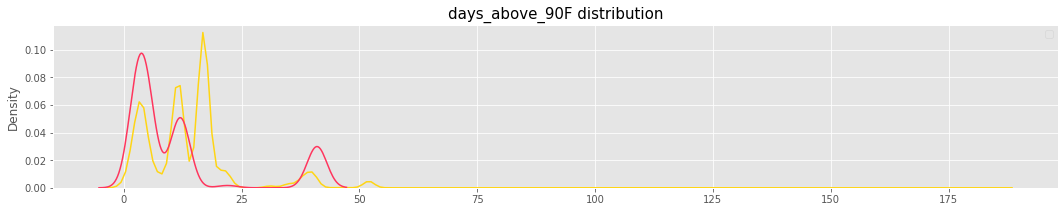

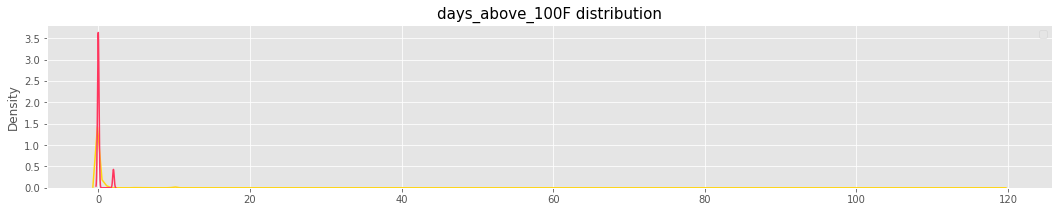

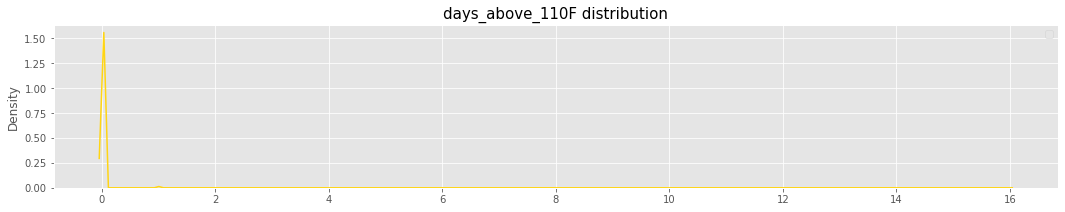

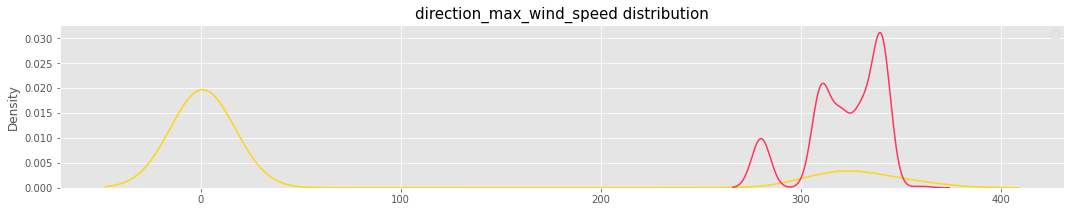

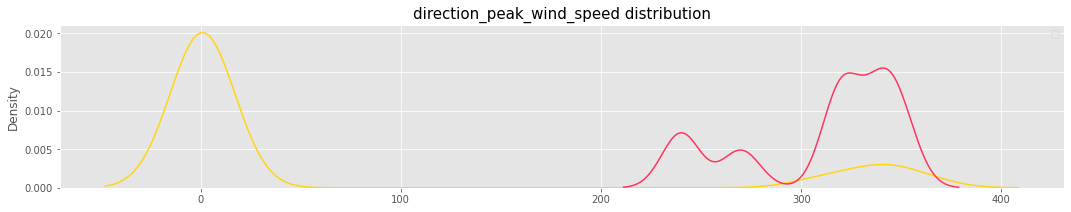

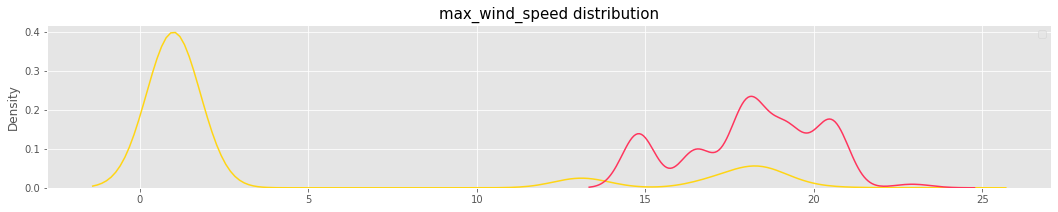

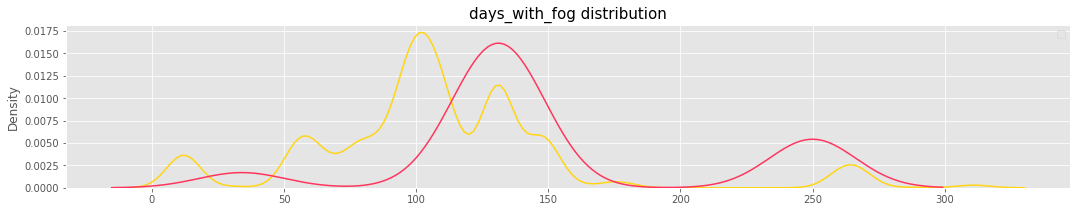

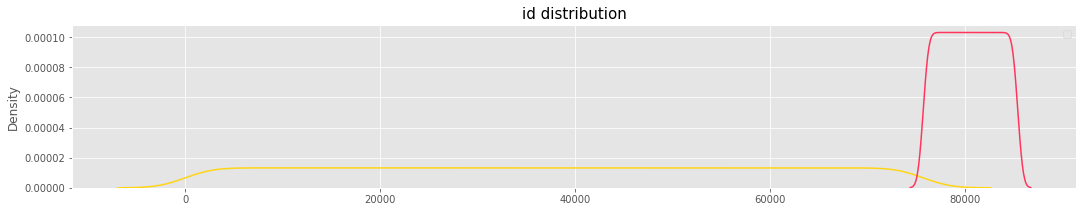

In [11]:
# plot distributions of features
for feature in numerical_features:
    if feature != "site_eui":
        kdeplot_features(train,test, feature=feature, title = feature + " distribution")

# **<span style="color:#F7B2B0;">Distribution of Categorical Variables</span>**

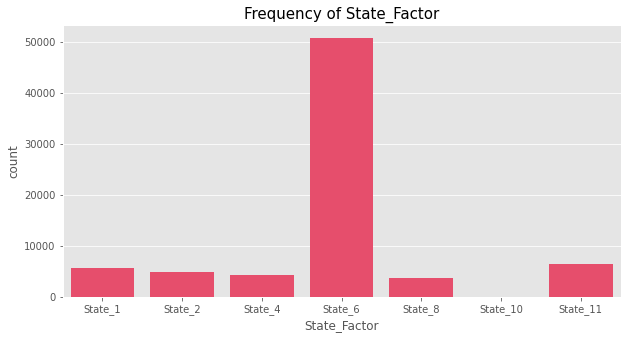

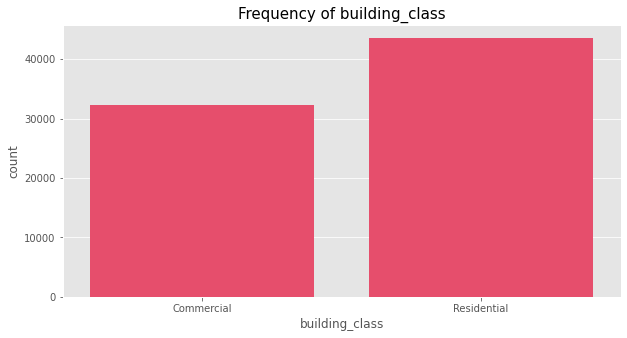

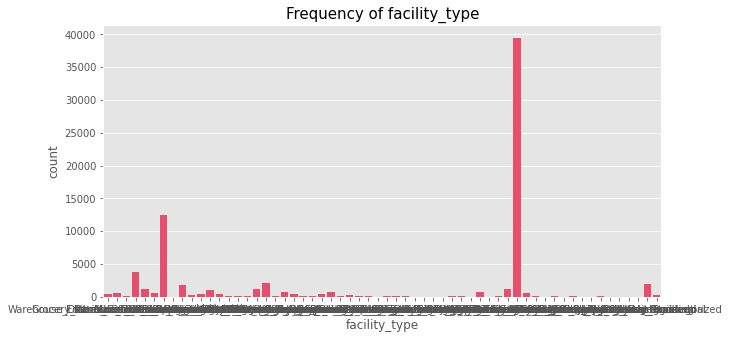

In [12]:
# plot distributions of categorical features
for feature in categorical_features:
    fig = countplot_features(train, feature=feature, title = "Frequency of "+ feature)

In [13]:
# Log Plots to W&B environment
title = "Distribution of Numerical features"
run = wandb.init(project='WiDSDatathon2022', name=title,anonymous=anony,config=CONFIG)
for feature in numerical_features:
    if feature != "site_eui":
        title = "Distribution of Numerical "+feature    
        create_wandb_hist(x_data=train[feature],x_name=feature , title=title,log="hist")    
wandb.finish()

title = "Countplot Distribution"
run = wandb.init(project='WiDSDatathon2022', name=title,anonymous=anony,config=CONFIG)    
for feature in categorical_features:
    #fig = countplot_features(train, feature=feature, title = feature + " countplot distribution")
    wandb.log({feature + " countplot distribution": fig})
wandb.finish()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously

wandb: Currently logged in as: anony-moose-182136 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [14]:
target = train["site_eui"]
train = train.drop(["site_eui","id"],axis =1)
test = test.drop(["id"],axis =1)

# **<span style="color:#F7B2B0;">Missing Values Imputation</span>**

In [15]:
#code copied from https://www.kaggle.com/shrutisaxena/wids2022-starter-code

# year_built: replace with current year.
train['year_built'] =train['year_built'].replace(np.nan, 2022)
#replacing rest of the values with mean
train['energy_star_rating']=train['energy_star_rating'].replace(np.nan,train['energy_star_rating'].mean())
train['direction_max_wind_speed']= train['direction_max_wind_speed'].replace(np.nan,train['direction_max_wind_speed'].mean())
train['direction_peak_wind_speed']= train['direction_peak_wind_speed'].replace(np.nan,train['direction_peak_wind_speed'].mean())
train['max_wind_speed']=train['max_wind_speed'].replace(np.nan,train['max_wind_speed'].mean())
train['days_with_fog']=train['days_with_fog'].replace(np.nan,train['days_with_fog'].mean())

##for testdata

# year_built: replace with current year.
test['year_built'] =test['year_built'].replace(np.nan, 2022)
#replacing rest of the values with mean
test['energy_star_rating']=test['energy_star_rating'].replace(np.nan,test['energy_star_rating'].mean())
test['direction_max_wind_speed']= test['direction_max_wind_speed'].replace(np.nan,test['direction_max_wind_speed'].mean())
test['direction_peak_wind_speed']= test['direction_peak_wind_speed'].replace(np.nan,test['direction_peak_wind_speed'].mean())
test['max_wind_speed']=test['max_wind_speed'].replace(np.nan,test['max_wind_speed'].mean())
test['days_with_fog']=test['days_with_fog'].replace(np.nan,test['days_with_fog'].mean())

# **<span style="color:#F7B2B0;">Label Encoding</span>**

In [16]:
le = LabelEncoder()

train['State_Factor']= le.fit_transform(train['State_Factor']).astype("uint8")
test['State_Factor']= le.fit_transform(test['State_Factor']).astype("uint8")

train['building_class']= le.fit_transform(train['building_class']).astype("uint8")
test['building_class']= le.fit_transform(test['building_class']).astype("uint8")

train['facility_type']= le.fit_transform(train['facility_type']).astype("uint8")
test['facility_type']= le.fit_transform(test['facility_type']).astype("uint8")

# **<span style="color:#F7B2B0;">W & B Artifacts</span>**

An artifact as a versioned folder of data.Entire datasets can be directly stored as artifacts .

W&B Artifacts are used for dataset versioning, model versioning . They are also used for tracking dependencies and results across machine learning pipelines.Artifact references can be used to point to data in other systems like S3, GCP, or your own system.

You can learn more about W&B artifacts [here](https://docs.wandb.ai/guides/artifacts)

![](https://drive.google.com/uc?id=1JYSaIMXuEVBheP15xxuaex-32yzxgglV)

In [17]:
# Save train data to W&B Artifacts
train.to_csv("train_features.csv", index = False)
run = wandb.init(project='WiDSDatathon2022', name='training_data', anonymous=anony,config=CONFIG) 
artifact = wandb.Artifact(name='training_data',type='dataset')
artifact.add_file("./train_features.csv")

wandb.log_artifact(artifact)
wandb.finish()

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


# **<span style="color:#F7B2B0;">Feature Scaling</span>**

In [18]:
trainnames = copy.deepcopy(train)
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)


# **<span style="color:#F7B2B0;">Hyperparameter Tuning Using Optuna</span>**

[Source](https://github.com/optuna/optuna)

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. The code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

**Key Features**

Optuna has modern functionalities as follows:

📌 **Lightweight, versatile, and platform agnostic architecture**

Handle a wide variety of tasks with a simple installation that has few requirements.

📌 **Pythonic search spaces**

Define search spaces using familiar Python syntax including conditionals and loops.

📌 **Efficient optimization algorithms**

Adopt state-of-the-art algorithms for sampling hyperparameters and efficiently pruning unpromising trials.

📌 **Easy parallelization**

Scale studies to tens or hundreds or workers with little or no changes to the code.

📌 **Quick visualization**

Inspect optimization histories from a variety of plotting functions.

In [19]:
rkf = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)

params = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }

X = copy.deepcopy(train)  
y = copy.deepcopy(target)

study_tuner = optuna.create_study(direction='minimize')
dtrain = lgbm.Dataset(X, label=y)

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgbm.LightGBMTunerCV(params, 
                            dtrain, 
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=250,
                            time_budget=19800, # Time budget of 5 hours, we will not really need it
                            seed = 42,
                            folds=rkf,
                            num_boost_round=10000,
                            callbacks=[lgbm.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
                           )

tuner.run()

[I 2022-01-07 18:03:57,628] A new study created in memory with name: no-name-e2b6b8c1-0267-4a77-8313-3ae5a2177862
min_data_in_leaf, val_score: 0.000000: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


In [20]:
print(tuner.best_params)
# Classification error
print(tuner.best_score)
# Or expressed as accuracy
print(1.0-tuner.best_score)

{'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
0.0
1.0


# **<span style="color:#F7B2B0;">LightGBM</span>**

[Source](https://github.com/microsoft/LightGBM)

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

📌 **Faster training speed and higher efficiency.**

📌 **Lower memory usage.**

📌 **Better accuracy.**

📌 **Support of parallel, distributed, and GPU learning.**

📌 **Capable of handling large-scale data.**


**LightGBM** is being widely-used in many winning solutions of machine learning competitions.

Comparison experiments on public datasets show that LightGBM can outperform existing boosting frameworks on both efficiency and accuracy, with significantly lower memory consumption. 



In [21]:
num_folds = 5
kf = KFold(n_splits = num_folds, random_state = 42)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    train_X = train[train_index]
    val_X = train[val_index]
    train_y = target[train_index]
    val_y = target[val_index]
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 1.0,
            'bagging_freq' : 0
             
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0])
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 1.0,
            'bagging_freq' : 0
                         }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)


60605 60606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3621
[LightGBM] [Info] Number of data points in the train set: 60606, number of used features: 62
[LightGBM] [Info] Start training from score 1.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

# **<span style="color:#F7B2B0;">Feature Importance</span>**

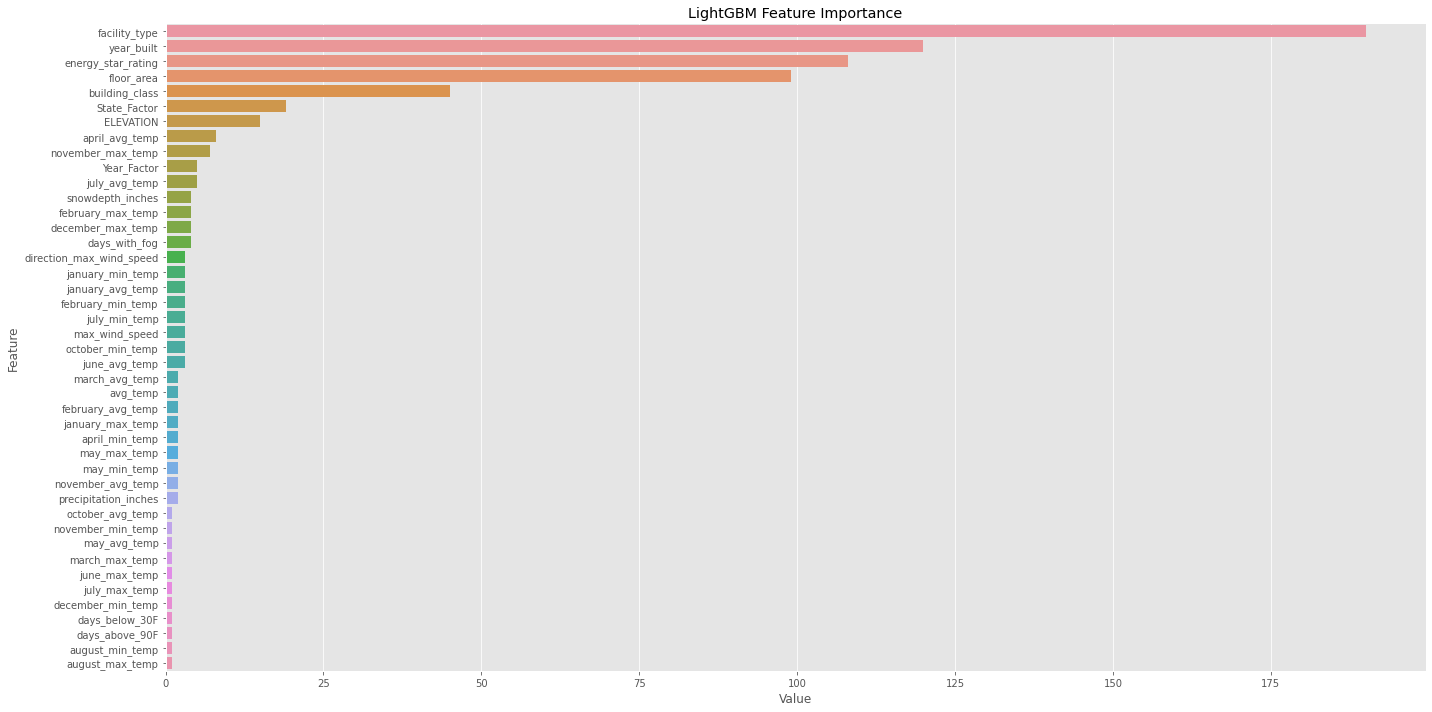

<Figure size 432x288 with 0 Axes>

In [22]:
feature_imp = pd.DataFrame(sorted(zip(gbm_regress.feature_importance(), trainnames.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

# **<span style="color:#F7B2B0;">SHAP VALUES</span>**

**SHAP (SHapley Additive exPlanations**) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

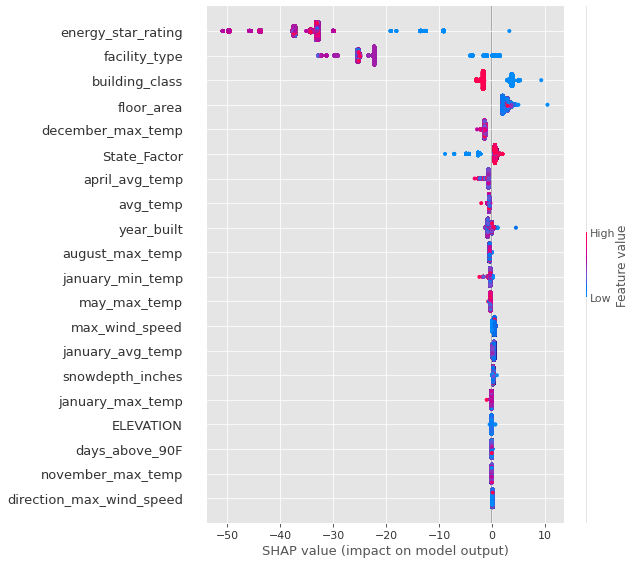

In [23]:
shap_values = shap.TreeExplainer(gbm_regress).shap_values(trainnames)
shap.summary_plot(shap_values, trainnames)

# **<span style="color:#F7B2B0;">Prediction on Test Data</span>**

In [24]:
res = gbm_regress.predict(test)